## Equipe:

- Ademir Guimarães
- Geovani Sampaio
- Gustavo Pacífico
- José Augusto


## Bibliotecas necessárias


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import math
import random

import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

## Análise Exploratória


In [3]:
TRAIN_PATH = 'ai_art_classification/train'
AI_GENERATED = f'{TRAIN_PATH}/AI_GENERATED'
NON_AI_GENERATED = f'{TRAIN_PATH}/NON_AI_GENERATED'

In [4]:
def count_images(path):
    return sum(len(files) for _, _, files in os.walk(path))

In [5]:
print(f'Número de imagens: {count_images(TRAIN_PATH)}')
print(f'Número de imagens geradas por IA: {count_images(AI_GENERATED)}')
print(f'Número de imagens não geradas por IA: {
      count_images(NON_AI_GENERATED)}')

Número de imagens: 18618
Número de imagens geradas por IA: 10330
Número de imagens não geradas por IA: 8288


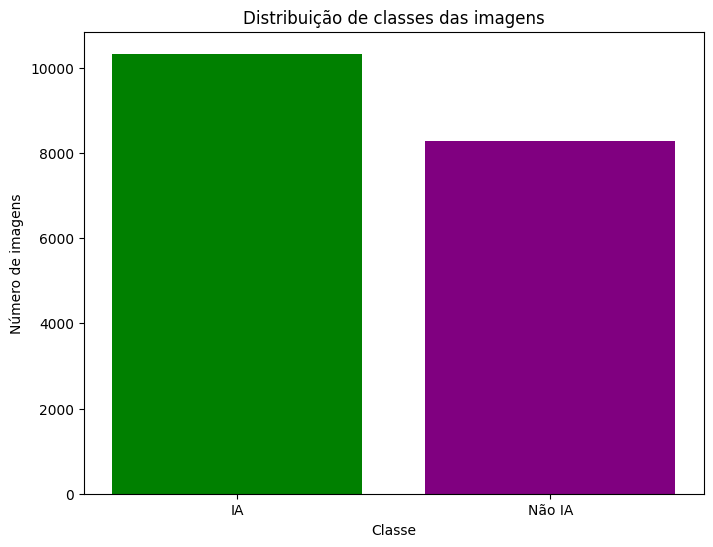

In [6]:
plt.figure(figsize=(8, 6))

labels = ['IA', 'Não IA']
counts = [count_images(AI_GENERATED), count_images(NON_AI_GENERATED)]
plt.bar(labels, counts, color=['green', 'purple'])
plt.title('Distribuição de classes das imagens')
plt.ylabel('Número de imagens')
plt.xlabel('Classe')
plt.show()

In [7]:
def print_image_shapes(path, name):
    shapes_set = set()
    image_names = os.listdir(path)

    if not image_names:
        print(f'O diretório {name} está vazio.')
        return

    for img_name in image_names:
        img = cv2.imread(os.path.join(path, img_name))
        if img is not None:
            shapes_set.add(img.shape)

    print(f'Número de dimensões únicas de imagem no conjunto {
          name}: {len(shapes_set)}')
    print(f'Dimensões das imagens no conjunto {name}: {shapes_set}')

In [8]:
print_image_shapes(AI_GENERATED, 'AI')
print_image_shapes(NON_AI_GENERATED, 'NON_AI')

Número de dimensões únicas de imagem no conjunto AI: 1
Dimensões das imagens no conjunto AI: {(512, 512, 3)}
Número de dimensões únicas de imagem no conjunto NON_AI: 1
Dimensões das imagens no conjunto NON_AI: {(512, 512, 3)}


In [9]:
def visualize_images(path, n_images, is_random=True, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.title(path.split('/')[-1])

    w = int(n_images ** .5)
    h = math.ceil(n_images / w)

    all_names = os.listdir(path)
    image_names = all_names[:n_images]
    if is_random:
        image_names = random.sample(all_names, n_images)

    for ind, image_name in enumerate(image_names):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    plt.show()

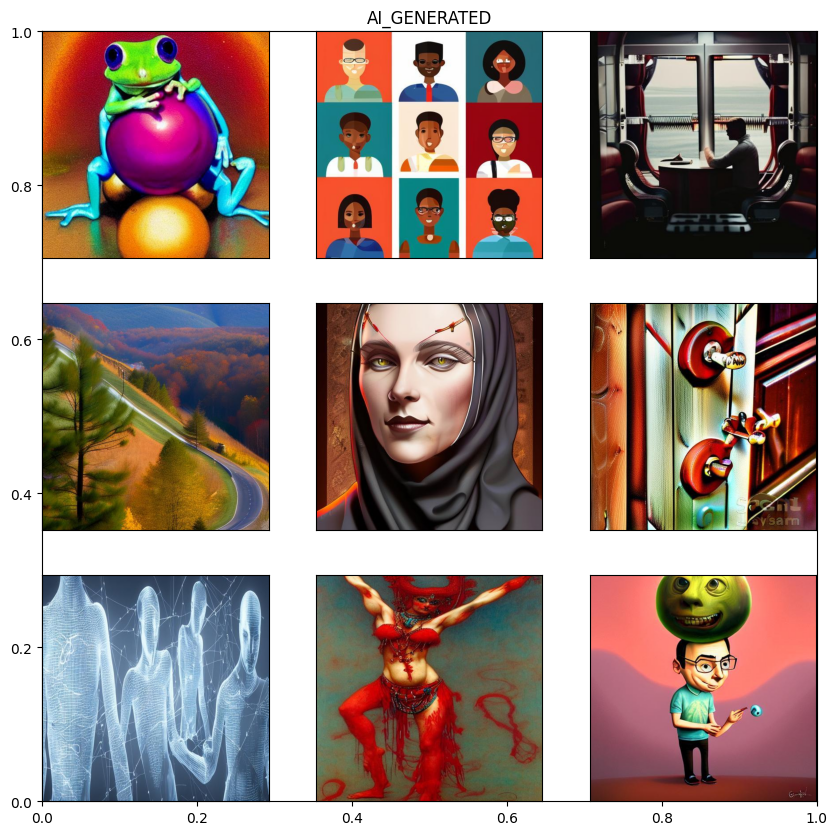

In [10]:
visualize_images(AI_GENERATED, 9)

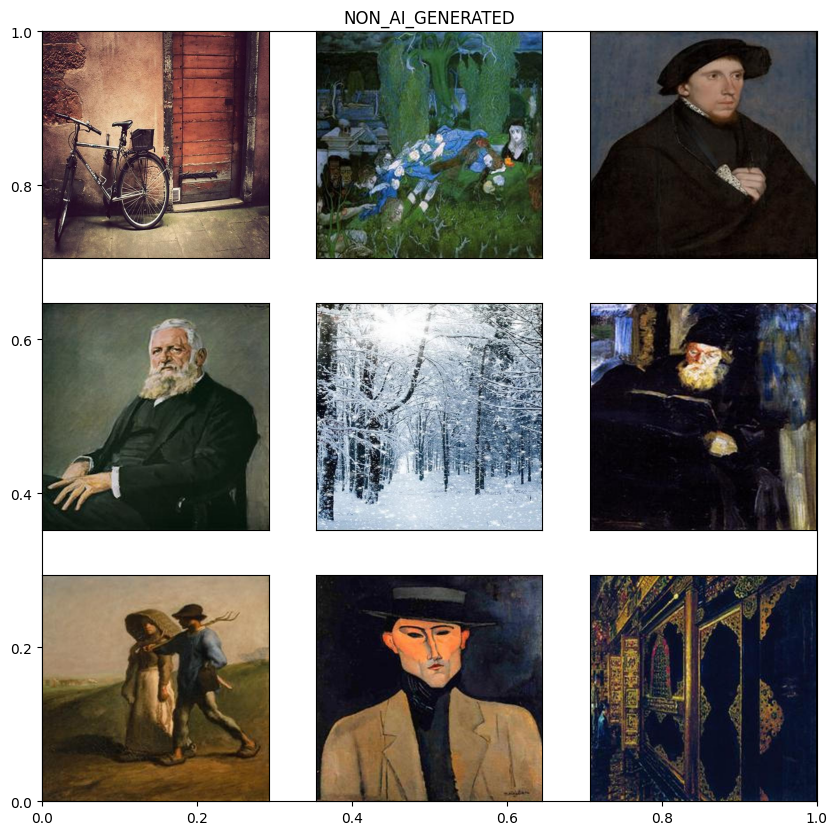

In [11]:
visualize_images(NON_AI_GENERATED, 9)

## Definindo modelo, iterador e hiperparâmetros


In [12]:
BATCH_SIZE = 32
IMG_SIZE = 180

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 18618 files belonging to 2 classes.
Using 14895 files for training.


In [14]:
val_ds  = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 18618 files belonging to 2 classes.
Using 3723 files for validation.


In [15]:
# Conversão do Dataset para arrays NumPy
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train, y_train = dataset_to_numpy(train_ds)
X_val, y_val = dataset_to_numpy(val_ds)

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
# criação do modelo para GridSearchCV
def create_model(learning_rate=1e-3, **kwargs):
    model = tf.keras.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [22]:
model = KerasClassifier(model=create_model, epochs=10, batch_size=32, verbose=0)

In [19]:
param_grid = {
    'model__learning_rate': [1e-2, 1e-3, 1e-4],
    'epochs': [1, 5, 10]
}

In [23]:
# Criação do GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
# melhores parâmetros e a melhor pontuação
print(f"Melhor: {grid_result.best_score_} usando os seguintes parêmtros: {grid_result.best_params_}")

In [ ]:
# Detalhes dos resultados
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print(f"Mean: {mean:.4f} Std: {std:.4f} with: {param}")

In [ ]:
# Treinamento do modelo com os melhores parametros encontrados
best_params = grid_result.best_params_
model = create_model(learning_rate=best_params['learning_rate'])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size']
)

In [ ]:
# resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(best_params['epochs'])

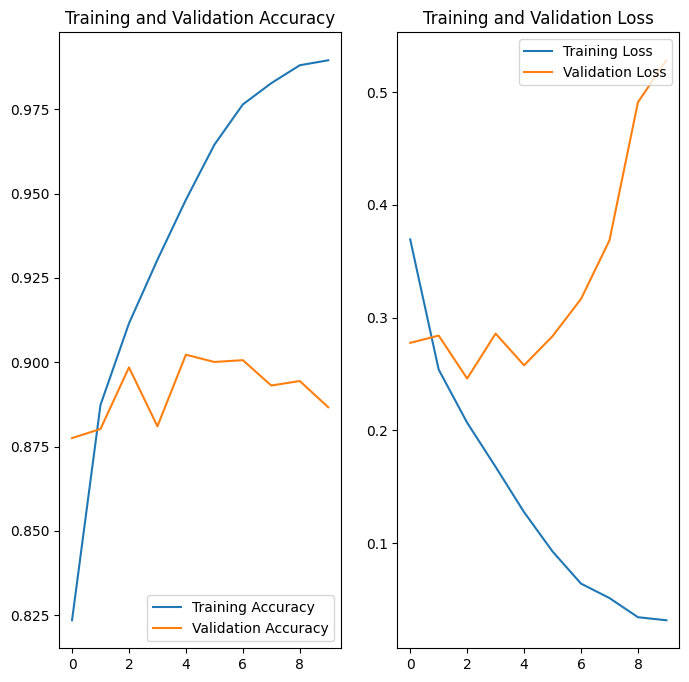

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Aplicando aumento de dados

In [ ]:
data_augmentation = tf.keras.Sequential(
[
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Rescaling(1./255),
    layers.RandomRotation(0.2),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
])